<a href="https://colab.research.google.com/github/AI-Biotechnology-Bioinformatics/Drug_Discovery_AI_Course_2026/blob/main/QSAR_Part_2_Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **AI And Biotechnology/Bioinformatics**

## **AI and Drug Discovery Course: QSAR Modeling**
This notebook demonstrates how to collect and preprocess bioactivity data from ChEMBL for QSAR modeling

# **Part 2: Exploratory Data Analysis**

## **Import Libraries**

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Import Bioactivity Dataset**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving bioactivity_preprocessed_data.csv to bioactivity_preprocessed_data.csv


In [3]:
df4 = pd.read_csv("bioactivity_preprocessed_data.csv")
df4.head(10)


,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL2396992,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,155000.0,inactive
1,CHEMBL2396992,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,342000.0,inactive
2,CHEMBL3218635,CC(C)[C@@H]1NC(=O)[C@@H](CC(N)=O)NC(=O)[C@H](C...,1200.0,intermediate
3,CHEMBL3218636,CCCC[C@H]1NC(=O)[C@@H](Cc2ccc3ccccc3c2)NC(=O)[...,10000.0,inactive
4,CHEMBL3218637,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,1800.0,intermediate
5,CHEMBL3218638,CC(C)C[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H...,200.0,active
6,CHEMBL3218639,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,10000.0,inactive
7,CHEMBL3218640,CC(C)C[C@@H]1NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](...,10000.0,inactive
8,CHEMBL3218641,CCCC[C@H]1NC(=O)[C@H](Cc2ccc(F)cc2)NC(=O)[C@H]...,700.0,active
9,CHEMBL3218642,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,1100.0,intermediate


## **Remove NA Values**

In [17]:
print("Original shape:", df4.shape)

df4 = df4.dropna(subset=[
    "molecule_chembl_id",
    "canonical_smiles",
    "standard_value"
])

# convert IC50 to numeric
df4["standard_value"] = pd.to_numeric(df4["standard_value"], errors="coerce")

df4 = df4.dropna(subset=["standard_value"])

df4 = df4[df4["bioactivity_class"] != 'intermediate']

print("After cleaning:", df4.shape)



Original shape: (5730, 4)
After cleaning: (4149, 4)


In [18]:
df4.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL2396992,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,155000.0,inactive
1,CHEMBL2396992,Cc1[nH]c2cc(Cl)cc(Cl)c2c1CCN,342000.0,inactive
3,CHEMBL3218636,CCCC[C@H]1NC(=O)[C@@H](Cc2ccc3ccccc3c2)NC(=O)[...,10000.0,inactive
5,CHEMBL3218638,CC(C)C[C@@H]1NC(=O)[C@H](CCCNC(=N)N)NC(=O)[C@H...,200.0,active
6,CHEMBL3218639,CC1(C)COC(=O)[C@H](Cc2ccccc2)NC(=O)[C@H](CCCNC...,10000.0,inactive


## **Aggregate Duplicates (median IC50 per structure)**

In [19]:
df_clean = (
    df4
    .groupby("canonical_smiles", as_index=False)
    .agg({
        "molecule_chembl_id": "first",
        "standard_value": "median",
        "bioactivity_class": "first"
    })
)

print("Before aggregation:", df4.shape[0])
print("After aggregation:", df_clean.shape[0])

df_clean.head()


Before aggregation: 4149
After aggregation: 2443


,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class
0,C#CC(=O)N1CC[C@H](C(=O)N(C)[C@H](C(=O)N[C@H]2C...,CHEMBL5821675,302.50,active
1,C#CCNc1cccc(F)c1-c1nc2c(cc1Cl)c(N1C[C@@H](C)N(...,CHEMBL5979784,67.00,active
2,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...,CHEMBL5930957,1.60,active
3,C#CCn1c(-c2cccnc2[C@H](C)OC)c2c3cc(ccc31)-c1cc...,CHEMBL5969896,5275.00,inactive
4,C#Cc1c(F)ccc2cc(N)cc(-c3ncc4c(N(C)[C@H]5C[C@@H...,CHEMBL5612217,1.99,active


## **Convert IC50 to pIC50**

Convert IC50 to the negative logarithmic scale which is essentially -log10(IC50). This conversion allows IC50 data to be more uniformly distributed.


In [20]:
df_clean["pIC50"] = -np.log10(df_clean["standard_value"] * 1e-9)

df_clean[["standard_value", "pIC50"]].head()


,standard_value,pIC50
0,302.50,6.519275
1,67.00,7.173925
2,1.60,8.795880
3,5275.00,5.277778
4,1.99,8.701147


## **Reassign Activity Labels Based on PIC50**

In [21]:
threshold = 6

df_clean["bioactivity_class"] = np.where(
    df_clean["pIC50"] >= threshold,
    "active",
    "inactive"
)

df_clean.head()


,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class,pIC50
0,C#CC(=O)N1CC[C@H](C(=O)N(C)[C@H](C(=O)N[C@H]2C...,CHEMBL5821675,302.50,active,6.519275
1,C#CCNc1cccc(F)c1-c1nc2c(cc1Cl)c(N1C[C@@H](C)N(...,CHEMBL5979784,67.00,active,7.173925
2,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...,CHEMBL5930957,1.60,active,8.795880
3,C#CCn1c(-c2cccnc2[C@H](C)OC)c2c3cc(ccc31)-c1cc...,CHEMBL5969896,5275.00,inactive,5.277778
4,C#Cc1c(F)ccc2cc(N)cc(-c3ncc4c(N(C)[C@H]5C[C@@H...,CHEMBL5612217,1.99,active,8.701147


## **Check Duplicates**

In [22]:
print("Duplicate SMILES remaining:",
      df_clean["canonical_smiles"].duplicated().sum())


Duplicate SMILES remaining: 0


In [26]:
df_clean.standard_value.describe()

,standard_value
count,2443.000000
mean,12750.921975
std,39285.783716
min,0.200000
25%,61.475000
50%,465.000000
75%,8409.750000
max,250000.000000


In [25]:
df_clean.pIC50.describe()

,pIC50
count,2443.000000
mean,6.252626
std,1.249463
min,3.602060
25%,5.075217
50%,6.332547
75%,7.211314
max,9.698970


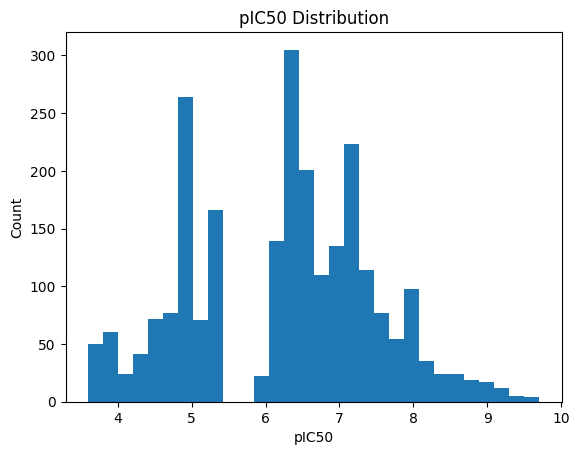

In [23]:
plt.hist(df_clean["pIC50"], bins=30)
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.title("pIC50 Distribution")
plt.show()

Text(0, 0.5, 'Frequency')

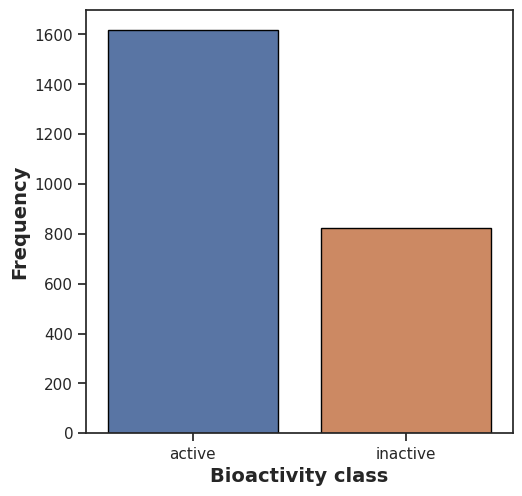

In [74]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x="bioactivity_class", data= df_clean, hue="bioactivity_class", edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')


# **Lipinski's Descriptor Calculation**

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:

**Molecular weight < 500 Dalton**  
**Octanol-water partition coefficient (LogP) < 5**  
**Hydrogen bond donors < 5**  
**Hydrogen bond acceptors < 10**

## **Install rdkit**

In [32]:
!pip install -q rdkit-pypi

     |████████████████████████████████| 29.2 MB 388 kB/s 


In [34]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import rdMolDescriptors

In [35]:
df_no_smiles = df_clean.drop(columns='canonical_smiles')

smiles = []

for i in df_clean.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key=len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name='canonical_smiles')

df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)

df_clean_smiles


,molecule_chembl_id,standard_value,bioactivity_class,pIC50,canonical_smiles
0,CHEMBL5821675,302.50,active,6.519275,C#CC(=O)N1CC[C@H](C(=O)N(C)[C@H](C(=O)N[C@H]2C...
1,CHEMBL5979784,67.00,active,7.173925,C#CCNc1cccc(F)c1-c1nc2c(cc1Cl)c(N1C[C@@H](C)N(...
2,CHEMBL5930957,1.60,active,8.795880,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...
3,CHEMBL5969896,5275.00,inactive,5.277778,C#CCn1c(-c2cccnc2[C@H](C)OC)c2c3cc(ccc31)-c1cc...
4,CHEMBL5612217,1.99,active,8.701147,C#Cc1c(F)ccc2cc(N)cc(-c3ncc4c(N(C)[C@H]5C[C@@H...
...,...,...,...,...,...
2438,CHEMBL4855521,0.51,active,9.292430,[2H]C1([2H])Oc2ccc(F)c(F)c2-c2nc3c(cc2Cl)c(N2C...
2439,CHEMBL5275944,50.00,active,7.301030,[2H][C@H]1CN2CCC[C@@]2(COc2nc(N3CC4CCC3CN4)c3c...
2440,CHEMBL6052900,16667.00,inactive,4.778143,[O-][N+]12CCCC1(COc1nc(N3CC4CCC(C3)N4)c3cnc(-c...
2441,CHEMBL5753679,8447.00,inactive,5.073298,[O-][S+]1CCC(Oc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cc(...


## **Calculate descriptors**

In [36]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors



In [37]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski.head(10)

,MW,LogP,NumHDonors,NumHAcceptors
0,902.106,5.41630,3.0,11.0
1,628.152,5.72372,1.0,8.0
2,528.632,3.66000,2.0,8.0
3,898.118,5.87680,2.0,10.0
4,570.619,5.40660,1.0,7.0
5,571.603,5.53000,1.0,7.0
6,571.603,5.53000,1.0,7.0
7,571.603,5.53000,1.0,7.0
8,577.582,5.31190,1.0,7.0
9,571.603,5.53000,1.0,7.0


Combine Both datasets

In [38]:
df_clean_smiles.head()

,molecule_chembl_id,standard_value,bioactivity_class,pIC50,canonical_smiles
0,CHEMBL5821675,302.50,active,6.519275,C#CC(=O)N1CC[C@H](C(=O)N(C)[C@H](C(=O)N[C@H]2C...
1,CHEMBL5979784,67.00,active,7.173925,C#CCNc1cccc(F)c1-c1nc2c(cc1Cl)c(N1C[C@@H](C)N(...
2,CHEMBL5930957,1.60,active,8.795880,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...
3,CHEMBL5969896,5275.00,inactive,5.277778,C#CCn1c(-c2cccnc2[C@H](C)OC)c2c3cc(ccc31)-c1cc...
4,CHEMBL5612217,1.99,active,8.701147,C#Cc1c(F)ccc2cc(N)cc(-c3ncc4c(N(C)[C@H]5C[C@@H...


In [39]:
df_lipinski.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,902.106,5.41630,3.0,11.0
1,628.152,5.72372,1.0,8.0
2,528.632,3.66000,2.0,8.0
3,898.118,5.87680,2.0,10.0
4,570.619,5.40660,1.0,7.0


In [41]:
df_combined = pd.concat([df_clean_smiles, df_lipinski], axis=1)
df_combined.head()

,molecule_chembl_id,standard_value,bioactivity_class,pIC50,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL5821675,302.50,active,6.519275,C#CC(=O)N1CC[C@H](C(=O)N(C)[C@H](C(=O)N[C@H]2C...,902.106,5.41630,3.0,11.0
1,CHEMBL5979784,67.00,active,7.173925,C#CCNc1cccc(F)c1-c1nc2c(cc1Cl)c(N1C[C@@H](C)N(...,628.152,5.72372,1.0,8.0
2,CHEMBL5930957,1.60,active,8.795880,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...,528.632,3.66000,2.0,8.0
3,CHEMBL5969896,5275.00,inactive,5.277778,C#CCn1c(-c2cccnc2[C@H](C)OC)c2c3cc(ccc31)-c1cc...,898.118,5.87680,2.0,10.0
4,CHEMBL5612217,1.99,active,8.701147,C#Cc1c(F)ccc2cc(N)cc(-c3ncc4c(N(C)[C@H]5C[C@@H...,570.619,5.40660,1.0,7.0


In [42]:
df_combined = df_combined.drop(columns="standard_value")
df_combined.head()

,molecule_chembl_id,bioactivity_class,pIC50,canonical_smiles,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL5821675,active,6.519275,C#CC(=O)N1CC[C@H](C(=O)N(C)[C@H](C(=O)N[C@H]2C...,902.106,5.41630,3.0,11.0
1,CHEMBL5979784,active,7.173925,C#CCNc1cccc(F)c1-c1nc2c(cc1Cl)c(N1C[C@@H](C)N(...,628.152,5.72372,1.0,8.0
2,CHEMBL5930957,active,8.795880,C#CCc1ccc(O)cc1-c1ncc2c(N3CC4CCC(C3)N4)nc(OCC3...,528.632,3.66000,2.0,8.0
3,CHEMBL5969896,inactive,5.277778,C#CCn1c(-c2cccnc2[C@H](C)OC)c2c3cc(ccc31)-c1cc...,898.118,5.87680,2.0,10.0
4,CHEMBL5612217,active,8.701147,C#Cc1c(F)ccc2cc(N)cc(-c3ncc4c(N(C)[C@H]5C[C@@H...,570.619,5.40660,1.0,7.0


## **Exploratory Data Analysis or Chemical Space Analysis For Lipinski Descriptors**

## **Import library**

In [43]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## **Barplot of the bioactivity classes**

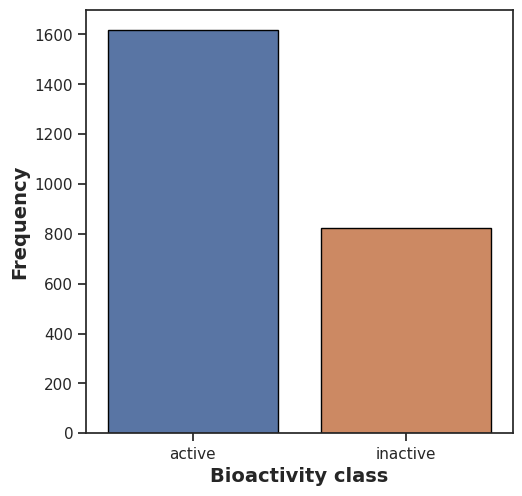

In [73]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x="bioactivity_class", data= df_combined, hue="bioactivity_class", edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

## **Boxplot of the bioactivity classes for PIC50**

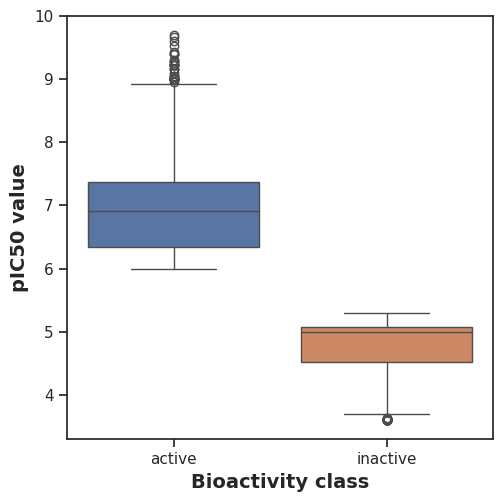

In [72]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = "bioactivity_class", y = "pIC50", data = df_combined, hue="bioactivity_class")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

## **Scatter of Molecular Weight vs Solubility (LogP)**

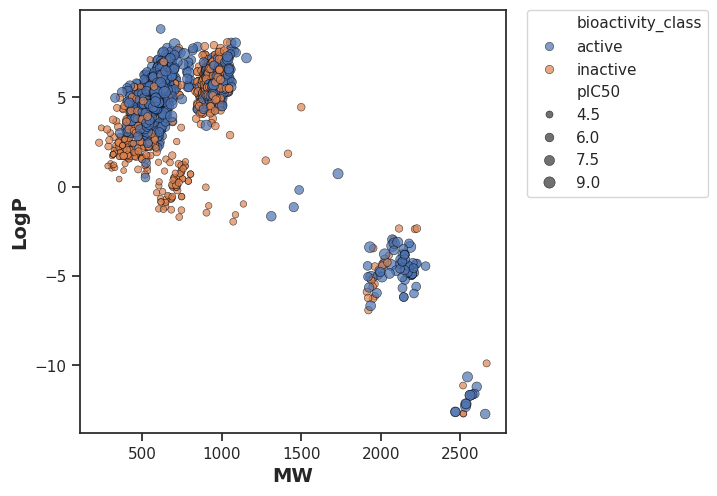

In [54]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_combined, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

## **Statistical analysis (Mann-Whitney U Test)**

In [55]:
def mannwhitney(descriptor, df_combined, verbose=False):
    """
    Perform Mann-Whitney U test between active and inactive compounds
    for a given descriptor.

    Parameters:
    - descriptor : str, column name of the descriptor
    - df_combined : pandas DataFrame, must have columns [descriptor, bioactivity_class]
    - verbose : bool, if True prints the test statistics

    Returns:
    - results : pandas DataFrame with test statistics, p-value, and interpretation
    """
    from numpy.random import seed
    from scipy.stats import mannwhitneyu
    import pandas as pd

    # set seed for reproducibility
    seed(1)

    # select only relevant columns
    df = df_combined[[descriptor, 'bioactivity_class']]

    # separate active and inactive compounds
    active = df[df['bioactivity_class'] == 'active'][descriptor]
    inactive = df[df['bioactivity_class'] == 'inactive'][descriptor]

    # perform Mann-Whitney U test
    stat, p = mannwhitneyu(active, inactive)

    if verbose:
        print(f"Descriptor: {descriptor}")
        print(f"Statistics={stat:.3f}, p={p:.3f}")

    # interpret result
    alpha = 0.05
    if p > alpha:
        interpretation = 'Same distribution (fail to reject H0)'
    else:
        interpretation = 'Different distribution (reject H0)'

    # store results in a DataFrame
    results = pd.DataFrame({
        'Descriptor': descriptor,
        'Statistics': stat,
        'p': p,
        'alpha': alpha,
        'Interpretation': interpretation
    }, index=[0])

    # save results to CSV
    filename = 'mannwhitneyu_' + descriptor + '.csv'
    results.to_csv(filename, index=False)

    return results


In [59]:
mannwhitney("pIC50", df_combined, verbose=True)

Descriptor: pIC50
Statistics=1334850.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1334850.0,0.0,0.05,Different distribution (reject H0)


In [60]:
mannwhitney("MW", df_combined, verbose=True)

Descriptor: MW
Statistics=675238.500, p=0.636


,Descriptor,Statistics,p,alpha,Interpretation
0,MW,675238.5,0.635606,0.05,Same distribution (fail to reject H0)


In [62]:
mannwhitney("LogP", df_combined, verbose=True)

Descriptor: LogP
Statistics=793193.000, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,793193.0,2.390207e-14,0.05,Different distribution (reject H0)


In [63]:
mannwhitney("NumHDonors", df_combined, verbose=True)

Descriptor: NumHDonors
Statistics=491642.500, p=0.000


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,491642.5,1.019302e-28,0.05,Different distribution (reject H0)


In [64]:
mannwhitney("NumHAcceptors", df_combined, verbose=True)

Descriptor: NumHAcceptors
Statistics=656825.500, p=0.518


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,656825.5,0.517512,0.05,Same distribution (fail to reject H0)


## **Molecular Weight**

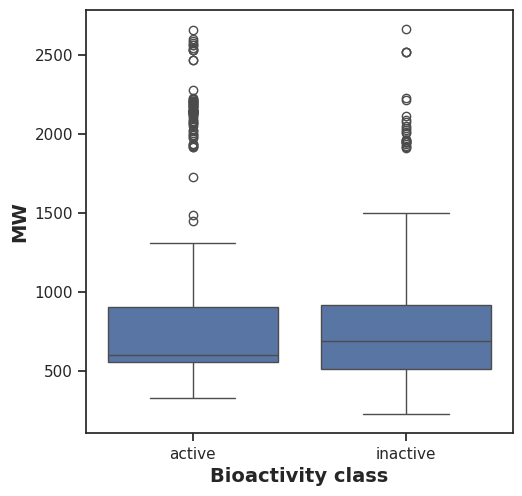

In [65]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_combined, hue="bioactivity_class")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')


## **logP**

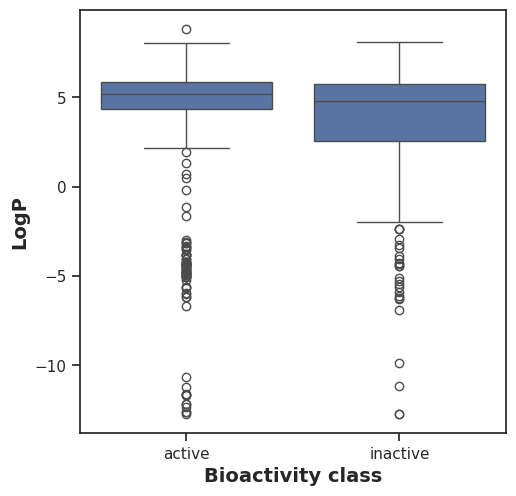

In [68]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = "bioactivity_class", y = 'LogP', data = df_combined, hue="bioactivity_class")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

## **NumHDonors**

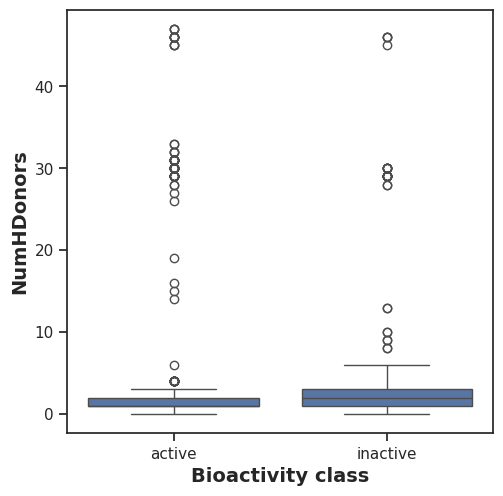

In [69]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = "bioactivity_class", y = "NumHDonors", data = df_combined, hue="bioactivity_class")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

## **NumHAcceptors**

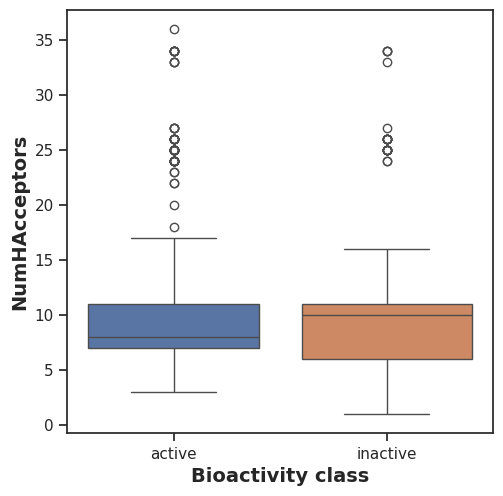

In [71]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = "bioactivity_class", y = "NumHAcceptors", data = df_combined, hue="bioactivity_class")

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

## **Save & Downlaod Results**

In [76]:
import pandas as pd
import glob
import os

# Get list of all Mann-Whitney CSV files in current folder
mw_files = glob.glob("mannwhitneyu_*.csv")

# Combine them into one DataFrame
mw_combined = pd.concat([pd.read_csv(f) for f in mw_files], ignore_index=True)

# Save combined CSV
combined_filename = "mannwhitney_summary.csv"
mw_combined.to_csv(combined_filename, index=False)

print(f"Combined Mann-Whitney CSV saved as {combined_filename}")

Combined Mann-Whitney CSV saved as mannwhitney_summary.csv


In [79]:
! zip -r EDA_results.zip . -i *mannwhitney_summary.csv *.pdf

  adding: plot_bioactivity_class.pdf (deflated 37%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_MW_vs_LogP.pdf (deflated 2%)
  adding: plot_MW.pdf (deflated 38%)
  adding: mannwhitney_summary.csv (deflated 47%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
